In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [73]:
from weatherbench2.metrics import MAE, _spatial_average

In [74]:
import graphufs

In [75]:
plt.style.use("graphufs.plotstyle")

In [76]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [77]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [78]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [79]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [80]:
truths = ["ERA5", "HRES Analysis"]
models = [
    "GraphUFS",
    "GraphCast",
    "Pangu",
#    "ERA5 Forecasts",
    "IFS ENS Mean",
    "Replay", # bit of a misnomer
]

In [81]:
duration = "240h"
year = 2018

location = "/p1-evaluation/v1/validation"

errors = {}

for model in models:
    name = model.lower().replace(" ", "_")
    errors[model] = {}
    middle = duration if model in ("GraphUFS", "Replay") else year
    
    for truth in truths:
        tname = truth.lower().replace(" ", "_")
        errors[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{middle}_deterministic.nc")

In [82]:
def plot_surface_metrics(
    mds,
    truth,
    metric="mae",
    fields=("2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(ncols*3, 4), constrained_layout=True)

    for i, (fld, ax) in enumerate(zip(fields, axs)):
        
        for j, (label, xdict) in enumerate(mds.items()):
            xds = xdict[truth]
            kw = {
                "ax": ax,
                "color": f"C{j}" if label != "Replay" else "gray",
            }
            if xds is not None:
                if fld in xds:
                    xds[fld].sel(metric=metric).plot(label=label if i == 0 else None, **kw)
    
        fname = " ".join([x.capitalize() if x != "of" else x for x in fld.replace("_", " ").split(" ")])
        title = fname
        xticks = mds["GraphUFS"][truth].fhr.values[3::4]
        ylim = [0, None] if metric == "mae" else [None, None]
        ax.set(
            xlabel="Lead time (days)",
            ylabel="",
            title=title,
            xticks=xticks,
            xticklabels=[x//24 for x in xticks],
            ylim=ylim,
            xlim=[-6, 252],
        )
    
    fig.legend(loc="center left", bbox_to_anchor=(1, .5))
    mname = metric.upper() if metric != "bias" else "Bias"
    fig.suptitle(f"{mname} vs {truth}")
    return fig, axs

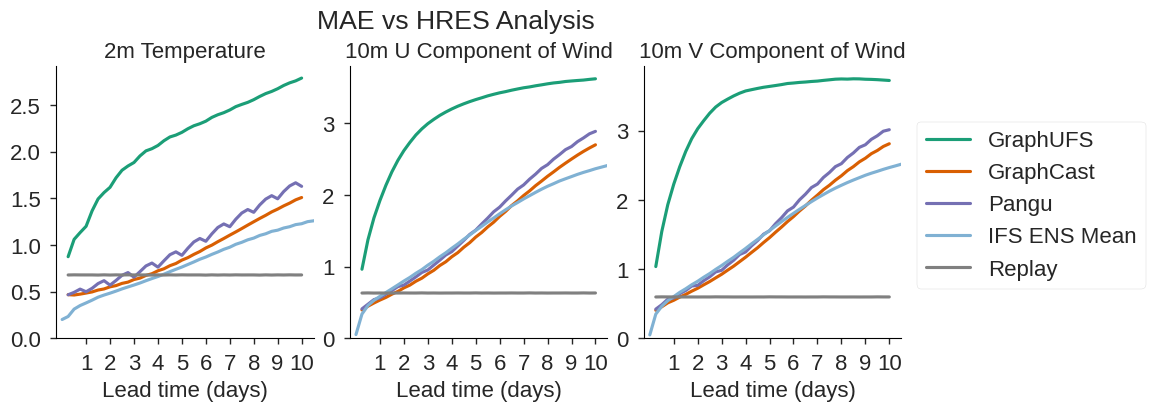

In [83]:
fig, axs = plot_surface_metrics(errors, truth="HRES Analysis")
fig.savefig(f"{fig_dir}/mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

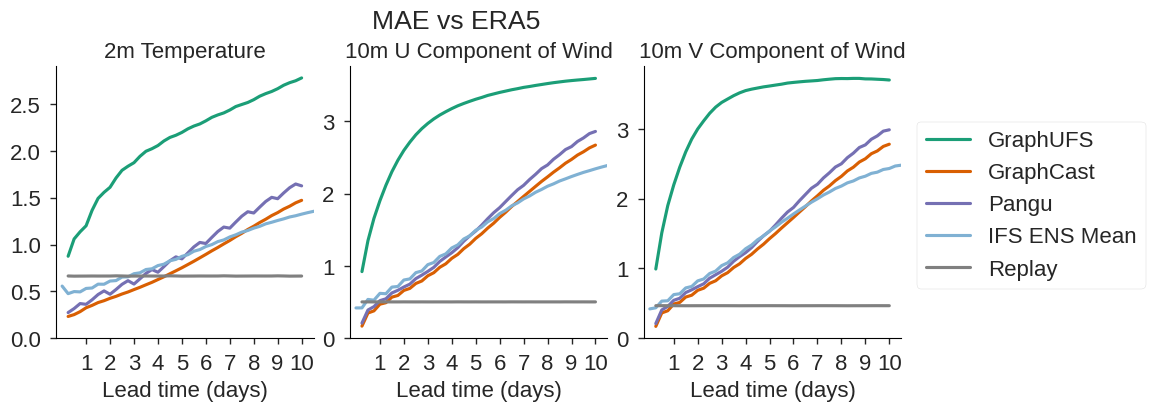

In [84]:
fig, axs = plot_surface_metrics(errors, truth="ERA5")
fig.savefig(f"{fig_dir}/mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

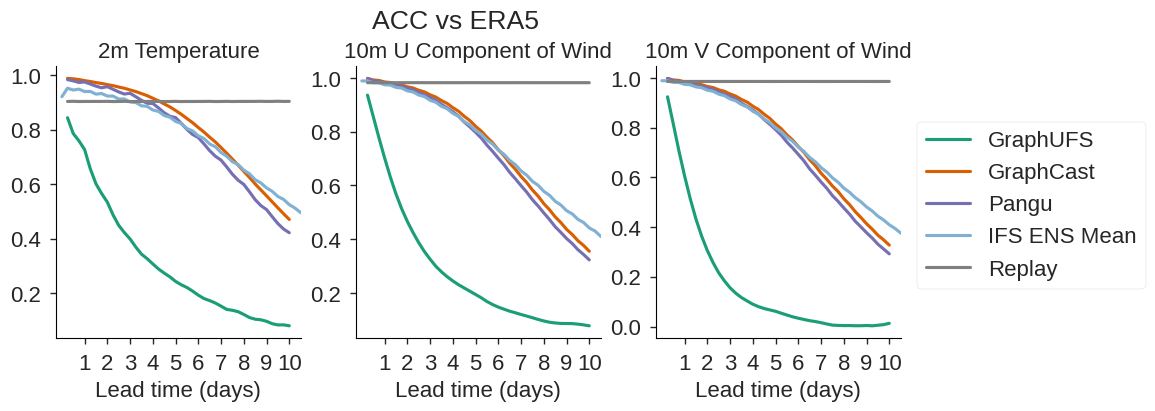

In [85]:
fig, axs = plot_surface_metrics(errors, truth="ERA5", metric="acc")
fig.savefig(f"{fig_dir}/acc_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

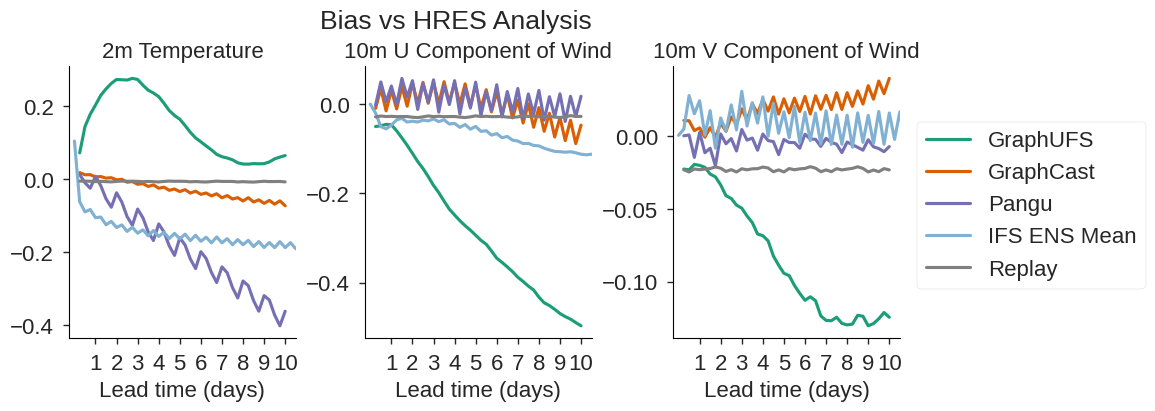

In [86]:
fig, axs = plot_surface_metrics(errors, truth="HRES Analysis", metric="bias")
fig.savefig(f"{fig_dir}/bias_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

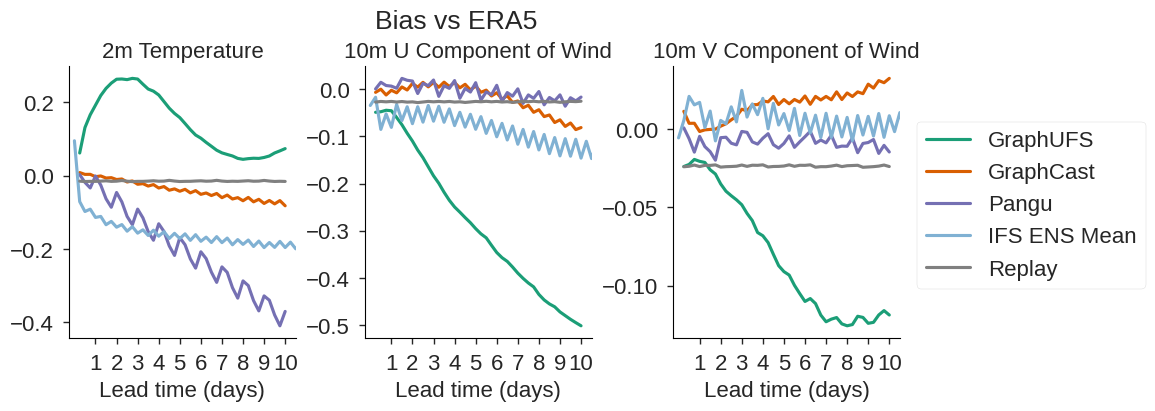

In [87]:
fig, axs = plot_surface_metrics(errors, truth="ERA5", metric="bias")
fig.savefig(f"{fig_dir}/bias_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

## Relative Error

Originally I was thinking
$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}_1, \text{trainer}_2)}$$

e.g. the ERA5 version of the plot shows

$$ \dfrac{|\text{GraphUFS} - \text{Replay}|}{|\text{Replay} - \text{ERA5}|}$$
or
$$ \dfrac{|\text{GraphCast} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
$$ \dfrac{|\text{Pangu} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
and same for Pangu.

Ideally we could also do

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}, \text{independent dataset})}$$

But we don't have error between ERA5 and HRES Analysis immediately available, so the HRES version of the plot shows

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{Replay}, \text{HRES Analysis})}$$

Which no matter what gives us some kind of independent estimate of "how close we should be" for the denominator, even when we use it on a dataset trained on ERA5.

In [88]:
gvr = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")

In [89]:
relative_errors = {
    "GraphUFS": {
        "HRES Analysis": gvr / errors["Replay"]["HRES Analysis"],
        "ERA5": gvr / errors["Replay"]["ERA5"],
    },
}

In [90]:
for key in ["GraphCast", "Pangu"]:
    relative_errors[key] = {
        "HRES Analysis": errors[key]["ERA5"] / errors["Replay"]["HRES Analysis"],
        "ERA5": errors[key]["ERA5"] / errors["Replay"]["ERA5"],
    }

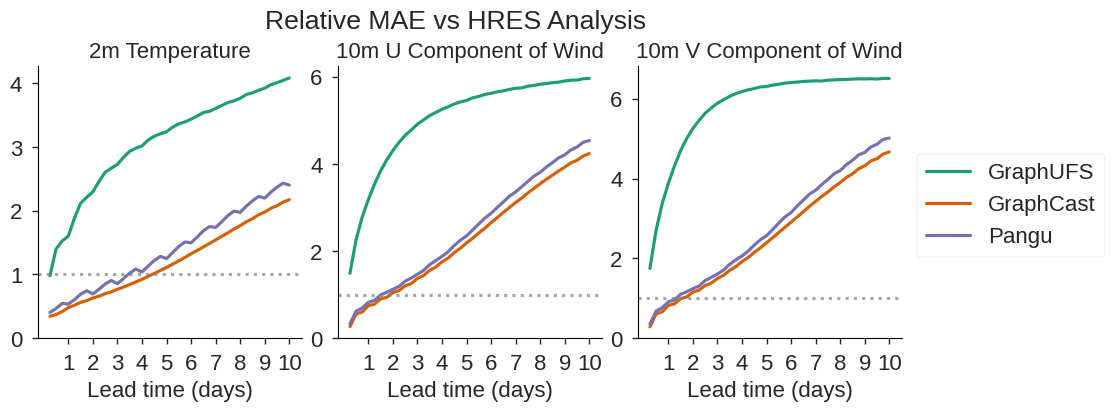

In [91]:
fig, axs = plot_surface_metrics(
    mds=relative_errors,
    truth="HRES Analysis",
)
fig.suptitle("Relative MAE vs HRES Analysis")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

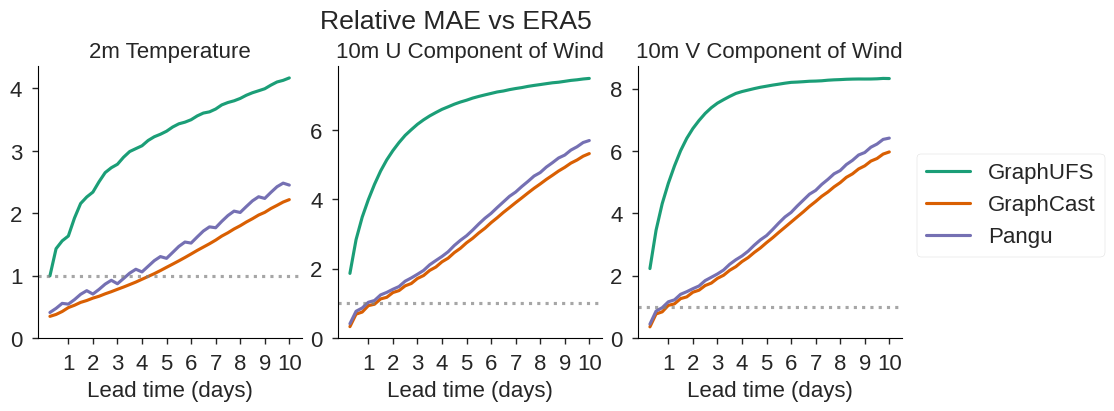

In [92]:
fig, axs = plot_surface_metrics(
    mds=relative_errors,
    truth="ERA5",
)
fig.suptitle("Relative MAE vs ERA5")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)